# Input dataset

In [1]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/root/data/imagenette_ours_50/train/', # your data here
    target_size=(224, 224),
    batch_size=100,
    class_mode='categorical',
    shuffle=True # set True to train the model from scratch
    )

number_of_classes = 10

2023-11-11 12:07:36.671160: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-11 12:07:37.841905: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 9972 images belonging to 10 classes.


In [2]:
val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
    '/root/data/imagenette_ours_50/val', # your data here
    target_size=(224, 224),
    batch_size=100,
    class_mode='categorical',
    shuffle=True # set True to train the model from scratch
    )

Found 3925 images belonging to 10 classes.


# Train from scratch

In [3]:
from keras.applications import ResNet101

model = ResNet101(weights=None,
                 include_top=True,
                 input_shape=(224, 224, 3),
                 classes=number_of_classes)

2023-11-11 12:07:47.385187: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:67:02.0, compute capability: 7.0


In [4]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),  
              metrics=['acc'])

In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=99,  # steps = total samples / batch size
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/50


2023-11-10 20:56:53.180475: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-10 20:56:54.766563: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5610ebeefef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-10 20:56:54.766606: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-11-10 20:56:54.783972: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-10 20:56:54.999210: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


99/99 [==============================] - 154s 879ms/step - loss: 2.2373 - acc: 0.2607 - val_loss: 3.6048 - val_acc: 0.1017
Epoch 2/50
99/99 [==============================] - 57s 569ms/step - loss: 1.8745 - acc: 0.3505
Epoch 3/50
99/99 [==============================] - 57s 569ms/step - loss: 1.7454 - acc: 0.4057
Epoch 4/50
99/99 [==============================] - 57s 566ms/step - loss: 1.6183 - acc: 0.4445
Epoch 5/50
99/99 [==============================] - 56s 565ms/step - loss: 1.4996 - acc: 0.4902
Epoch 6/50
99/99 [==============================] - 56s 562ms/step - loss: 1.3889 - acc: 0.5340
Epoch 7/50
99/99 [==============================] - 56s 563ms/step - loss: 1.2662 - acc: 0.5704
Epoch 8/50
99/99 [==============================] - 56s 564ms/step - loss: 1.1566 - acc: 0.6102
Epoch 9/50
99/99 [==============================] - 56s 559ms/step - loss: 1.0467 - acc: 0.6525
Epoch 10/50
99/99 [==============================] - 56s 557ms/step - loss: 0.9099 - acc: 0.7024
Epoch 11/50


In [10]:
model.save('./model/resnet101_ours_50.h5')

/root/miniconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Using pretrained model

In [5]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('./model/resnet101_ours_50.h5')

In [6]:
# Use the Global Pooling layer for final features
model.layers[-2]

# Extracting final features

In [7]:
original_datagen = ImageDataGenerator(rescale=1./255)
original_generator = original_datagen.flow_from_directory(
    '/root/data/imagenette/train/',
    target_size=(224, 224),
    batch_size=50,
    class_mode='categorical',
    shuffle=False)

Found 9471 images belonging to 10 classes.


In [8]:
from keras.models import Model
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)
train_features = feature_extractor.predict(original_generator)

2023-11-11 12:08:33.821483: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


190/190 [==============================] - 45s 221ms/step


In [8]:
validation_features = feature_extractor.predict(validation_generator)

79/79 [==============================] - 19s 226ms/step


In [9]:
dis_datagen = ImageDataGenerator(rescale=1./255)
distilled_generator = dis_datagen.flow_from_directory(
    '/root/data/Ours_v2_50ipc/',
    target_size=(224, 224),
    batch_size=50,
    class_mode='categorical',
    shuffle=False)

distilled_features = feature_extractor.predict(distilled_generator)

Found 500 images belonging to 10 classes.
10/10 [==============================] - 1s 99ms/step


# Visualization

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
                                     
tsne = TSNE(random_state=40, n_components=2,verbose=0, perplexity=30)
train_features_2d = tsne.fit_transform(train_features)

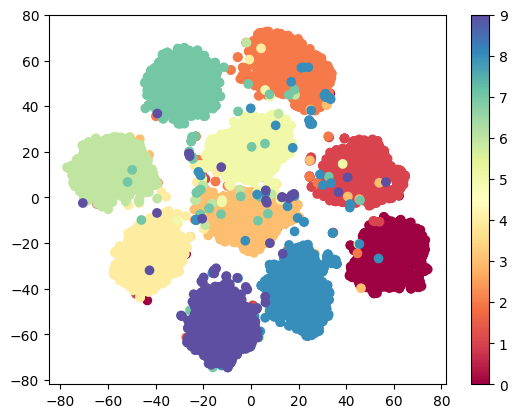

In [12]:
import numpy as np

train_labels = original_generator.classes

plt.scatter(train_features_2d[:, 0], train_features_2d[:, 1], c=train_labels, cmap='Spectral')
plt.colorbar()
plt.show()

In [10]:
import numpy as np
from sklearn.manifold import TSNE

labels = np.concatenate((original_generator.classes, distilled_generator.classes))
features = np.concatenate((train_features,distilled_features))

tsne = TSNE(random_state=40, n_components=2,verbose=0, perplexity=30)
features_2d = tsne.fit_transform(features)

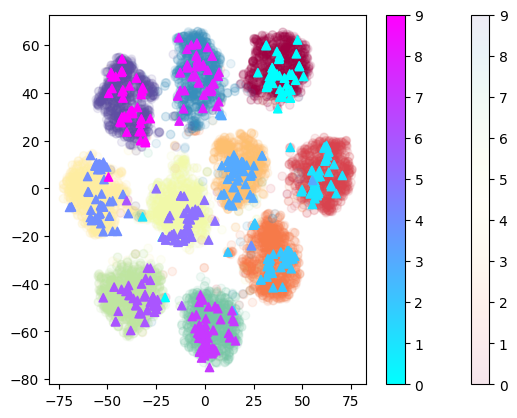

In [11]:
import matplotlib.pyplot as plt
original_features_2d = features_2d[:len(train_features)]
distilled_features_2d = features_2d[len(train_features):]
original_labels = labels[:len(train_features)]
distilled_labels = labels[len(train_features):]

fig, ax = plt.subplots()
scatter1 = ax.scatter(original_features_2d[:, 0], original_features_2d[:, 1], cmap='Spectral', c=original_labels, alpha=0.1)
plt.colorbar(scatter1, ax=ax)

scatter2 = ax.scatter(distilled_features_2d[:, 0], distilled_features_2d[:, 1], cmap='cool', c=distilled_labels, marker='^')
plt.colorbar(scatter2, ax=ax)
plt.show()

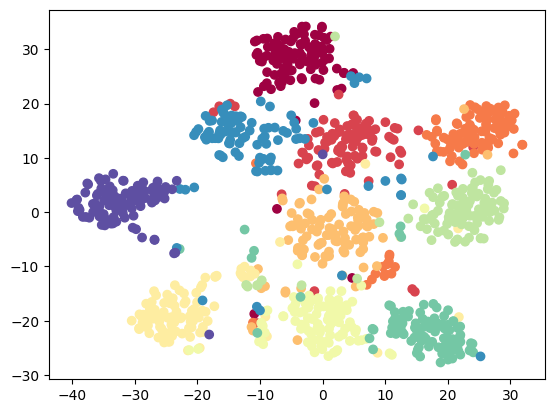

In [16]:
distilled_features_2d = tsne.fit_transform(distilled_features)
distilled_labels = distilled_generator.classes
plt.scatter(distilled_features_2d[:, 0], distilled_features_2d[:, 1], c=distilled_labels, cmap='Spectral')
plt.show()

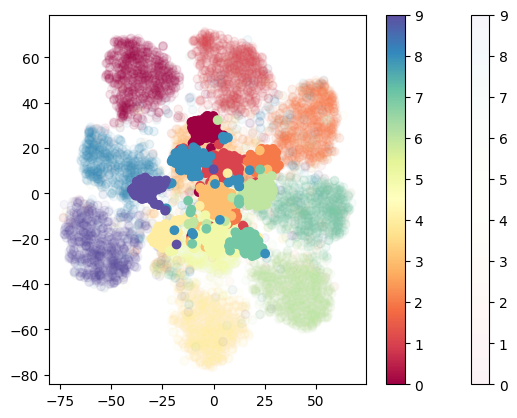

In [37]:
fig, ax = plt.subplots()

scatter1 = ax.scatter(train_features_2d[:, 0], train_features_2d[:, 1], c=train_labels, cmap='Spectral', alpha=0.05)
plt.colorbar(scatter1, ax=ax)

scatter2 = ax.scatter(distilled_features_2d[:, 0], distilled_features_2d[:, 1], c=distilled_labels, cmap='Spectral')
plt.colorbar(scatter2, ax=ax)

plt.show()

## Umap